# Project #6

Due Friday, Nov 2nd, 5pm.

1. You may implement the solution to this problem in any way that you wish.  You may use any iterative clustering type algorithm, which clusters based on the Manhattan ($L_1$) distance metric, which is less sensitive to outliers.  Assume that the $D$ features are real valued quantities, i.e., $x\in\mathbb{R}^D$  represents a sample.  The Manhattan distance between two samples $x$ and $y$ can be computed as
\begin{align}
d(x,y) = \sum_{i=1}^{D} |x_i - y_i|.
\end{align}
Test your algorithm on the toy data sets used in this example:
http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py, (i.e., your implemented algorithm with the Manhattan distance should add a column to the row of images). Commenting on what you .

2. The following tutorial shows you how to use Keras (and tensorflow) to perform supervised learning on the MINST fashion images.  https://www.tensorflow.org/tutorials/keras/basic_classification
    1. work through the tutorial. Explain in your own words what is auto-encoding.
    2. apply unsupervised learning to an appropriate **subset** data set (i.e. ignore the labels) to see if you can cluster the different types of clothing in this data set.


# Answer of Question 1

In this part, we are going to apply a Manhattan distance to the toy dataset. First of all, we can import the library that we are going to use based on the tutorial on the question.

In [52]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

 It is recommended to use different markers and colors for each class/clusters


Then, we can create toy dataset like the following code and produce some plots of classification methods differentiate by color for each. We can edit the code and add manhattan distance by using the folowing code `cluster.DBSCAN(metric="manhattan")` and add a new column to the figure called `Manhattan`.

### Before Adding Manhattan Distance

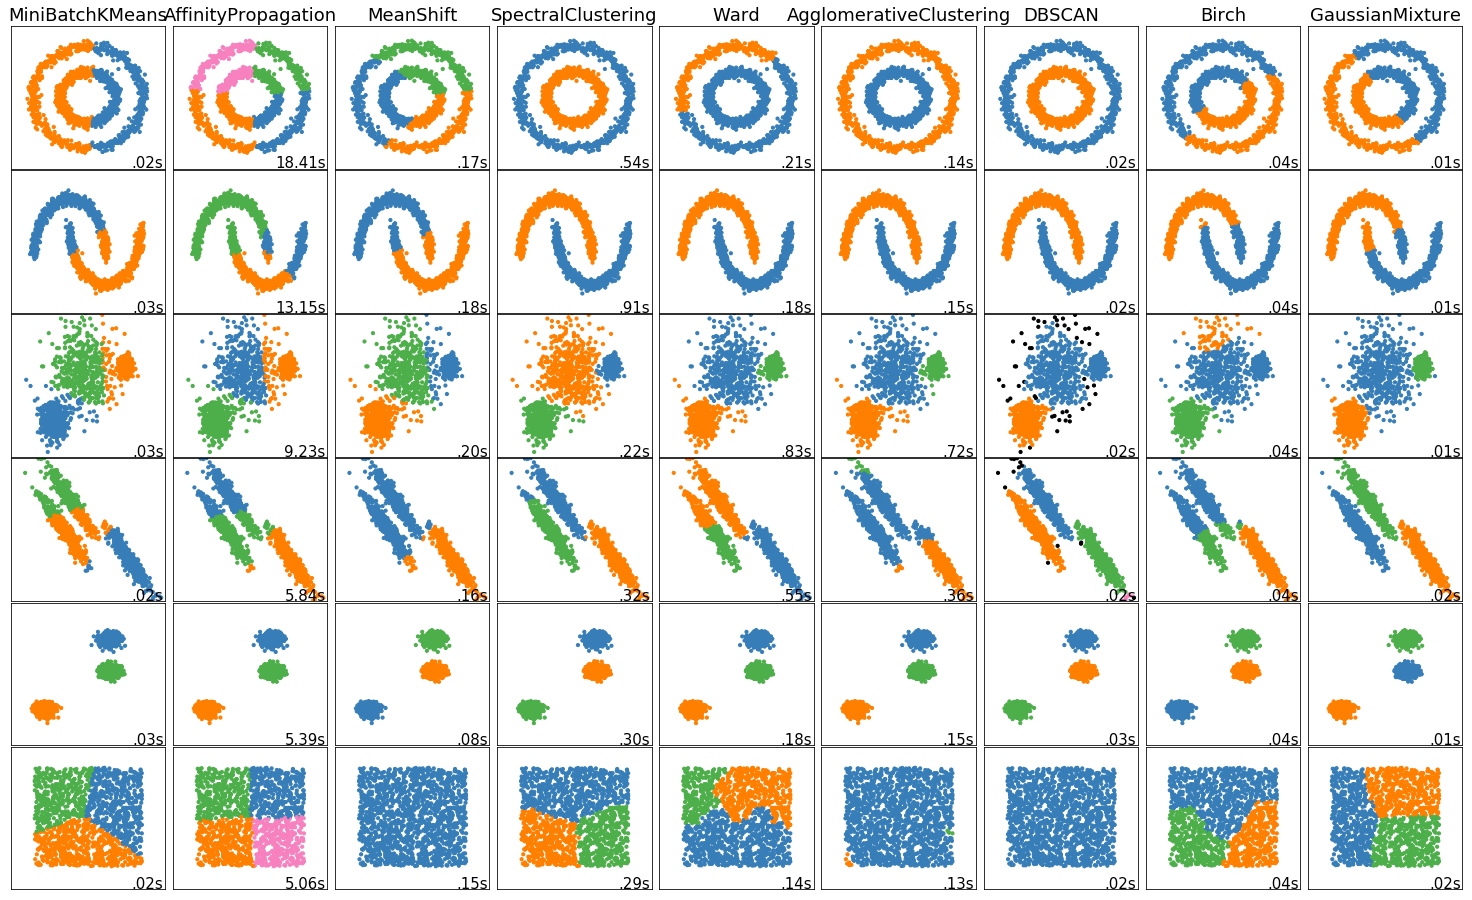

In [53]:
# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

### After Applying the Manhattan Distance

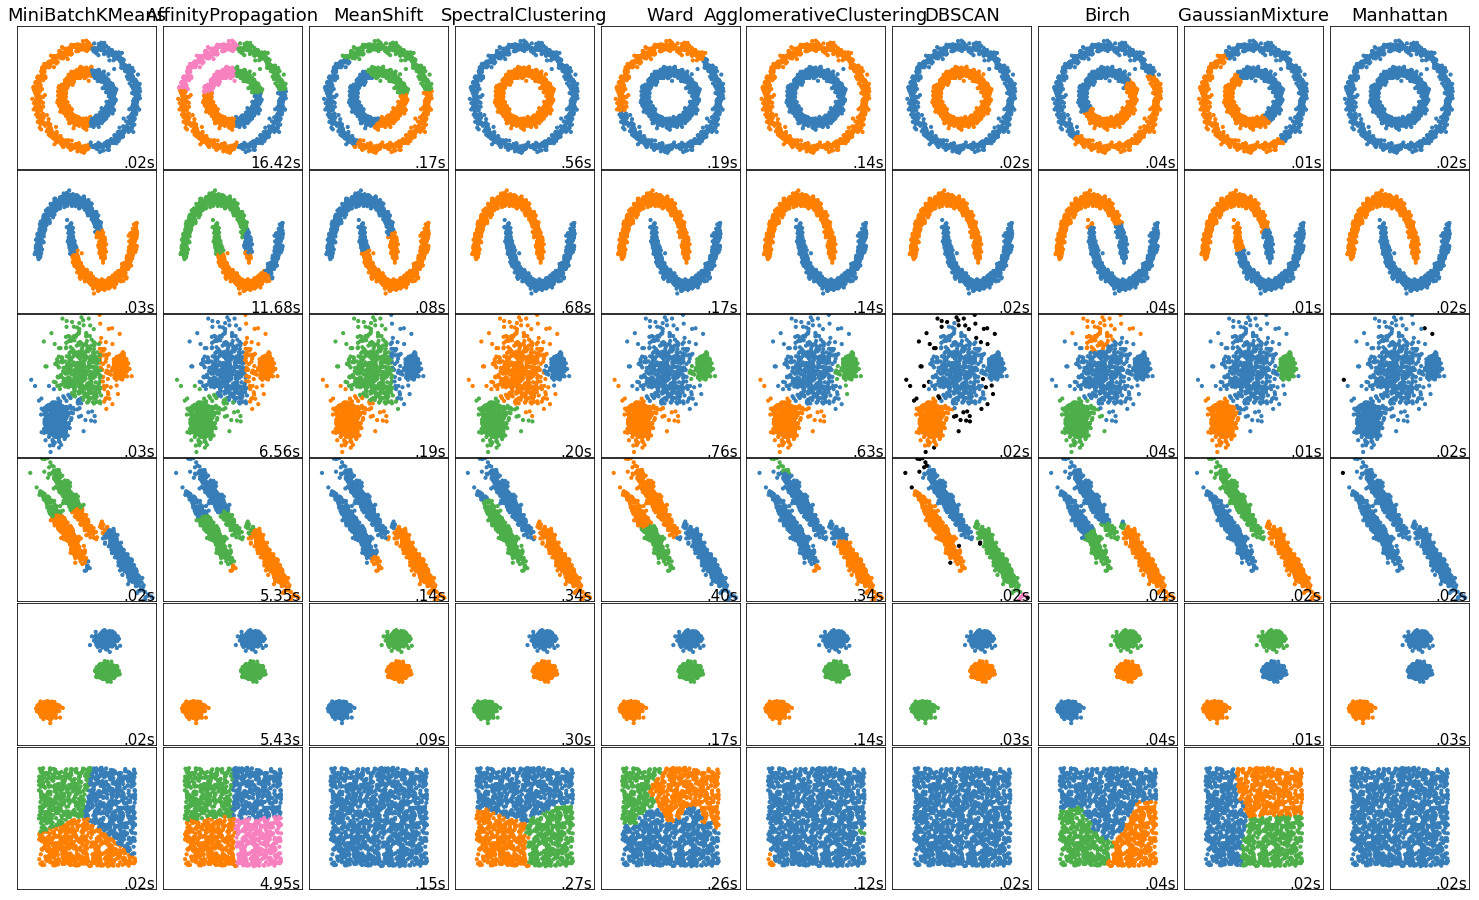

In [30]:
# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack',
        affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')
    #add the manhattan distance
    manhat = cluster.DBSCAN(metric="manhattan")

    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AffinityPropagation', affinity_propagation),
        ('MeanShift', ms),
        ('SpectralClustering', spectral),
        ('Ward', ward),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
        ('Birch', birch),
        ('GaussianMixture', gmm),
        ('Manhattan', manhat)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

In the output above, we can see the Manhattan has been applied and appeared in the right side of the figure above.
We can see that Manhattan distance does not produce a very good classification of the data compare to other. While the other classification able to classified the data into two groups and more, the manhattan only able to classified it into a maximum of two groups and most of the classification did not differentiate the data at all.

This is because of the difference in data and the calculation of both distance. In Manhattan, distance is calculated by the difference between vector a-b, while euclidean use a square root of vector a-b. Therefore, the classification produce a different result between the two.

In 2 dimensional vector, the Euclidean measure the distance of shortest path in the plane, while the Manhattan create a metric of the shortest path if we are allowed to move horizontally or vertically. Thereby, both measure the shortest path but the euclidean does not have any restriction on how to select the path, while manhattan only allows the paths that are constant in all but one dimension.


# Answer of Question 2

In this part, we are going to work through tutorial about using TensorFlow. The purpose of the guide is to train a neural network model to identify images related to clothing, shoes, sneakers, etc. To start working on this, we have to import the tensorflow package along with keras library. Th following code will add the package into this notebook.

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

When the packages is ready, we can import the dataset into this program. In this case, we are going to use Fashion MNIST dataset which contains 70000 grayscale images. To save memory and running time, we can transform the images into 28x28 pixels. We can split the data into train and test dataset. The following code will excute the data to be splitted into two.

In [32]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [20]:
train_images

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

The images values around 0 to 255, and the labels are an array of integer ranging between 0 to 9.
Lets named our class name like the following code.

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

We can further observe our dataset in order to have more understanding of the data looks like to know the purpose. We can compute the observations of our variable. The following code will help you compute the shape or numnber of observations in the dataset and understand the dataset better.

#### 1. Training Dataset

##### A. Compute the number of observations

In [4]:
train_images.shape

(60000, 28, 28)

The above output shows that we have 60000 observations of images with 28x28 pixels of quality for training dataset.

##### B. Compute the length of the variable train labels

Print out the length of variable train labels.

In [6]:
len(train_labels)

60000

We also have 60000 observations of training labels.

##### C. Check the variable

What the variable looks like:

In [7]:
train_labels

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

#### 2. Testing Dataset

##### A. Compute the number of observations

In [8]:
test_images.shape

(10000, 28, 28)

The above output shows that we have 10000 observations of image in the test observation for testing dataset. Like previously, we can also count the images labels.

##### B. Compute the length of the variable train labels

Print out the length of variable train labels.

In [8]:
len(test_labels)

10000

The above output shows an information that we have 10000.

##### C. Check the variable

What the variable looks like:

In [ ]:
train_labels

## Preprocess the data

We have to preprocess the data before we move to the next step of training the network. 
The following code will show one of the image wen we show it before processing the data further.

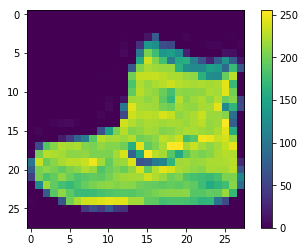

In [21]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)

We will scale the values to a range of 0 to 1, convert the datatype into float and dive the images variable with 255 before calling it in the neural network model. We have to keep in mind to process both images variables (training and testing) in the same way.

In [33]:
train_images = train_images / 255.0
test_images = test_images / 255.0

Lets take a look at the first 25 images from training dataset.

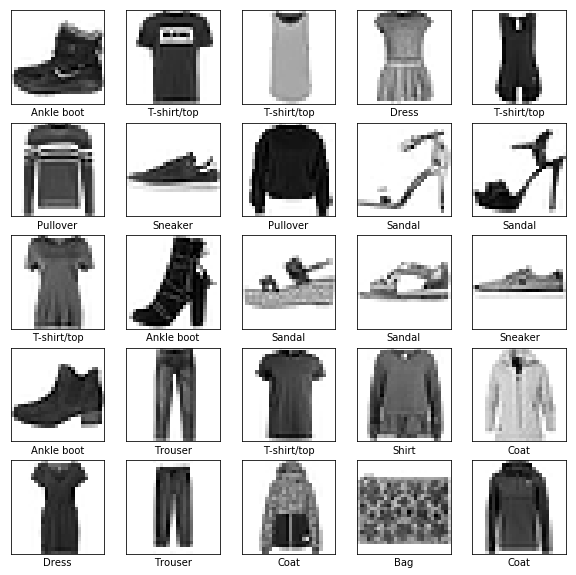

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])

As we can see, we are able to display the images in a grayscale format which means that the data is ready for building and train the model of neural network.

### Building the model

There are two steps to built the model which are configure the layer of the model and compile the model. The following code will setup the layers.

In [34]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)), 
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

There are three layers need to be set up in this model. The first layer will  transform the format of the images from a 2d-array of 28 by 28 pixels into a 1-d array of 28x28 = 784 pixels dimension. The first dense layer has 128 nodes and the second has 10 node of softmax layer which return an array of 10 probability scores sum to 1. Each node will contain the probability whether a current image is part of the 10 classes.

Then we can compile the model and some function to prepare it for training. We can add loss function to measure the accuracy of the model during training. The optimizer to update the model based on the data and its loss function. The metrics which used to monitor the training and testing steps. Lets take a look at the code below on how we implement the three functions.

In [35]:
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Train the model

There are several steps requires to train the neural network model.
* Add the training data(train_images and train_labels) into the model.
* Interacting the model to be familiar with the images and labels.
* Make a prediction of the test.

#### Fit the data

To begin the training, we can use the fit() function to fit the model to the training data.

In [39]:
train_images.shape

(60000, 28, 28)

In [37]:
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 8s 130us/step - loss: 0.4993 - acc: 0.8249
Epoch 2/5
60000/60000 [==============================] - 8s 131us/step - loss: 0.3740 - acc: 0.8653
Epoch 3/5
60000/60000 [==============================] - 7s 122us/step - loss: 0.3386 - acc: 0.8768
Epoch 4/5
60000/60000 [==============================] - 6s 107us/step - loss: 0.3119 - acc: 0.8848
Epoch 5/5
60000/60000 [==============================] - 6s 106us/step - loss: 0.2956 - acc: 0.8919


The above output shows the loss and accuracy metrics while the model is being train.

#### Evaluate the accuracy

Next, we can compare the performance of the model using the test dataset.

In [38]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', test_acc)

10000/10000 [==============================] - 1s 72us/step
Test accuracy: 0.8754


As shown on the above output, there is a little gap between the training set and the testing dataset accuracy. This is called overfitting which happen when the model perform worse on a new data compare to the training data.

#### Predict the data

Here the model will make a predictions about some images.

In [39]:
predictions = model.predict(test_images)

We can ake a look at the first prediction using the following code.

In [29]:
predictions[0]

array([1.8662936e-06, 2.7008978e-08, 1.1989459e-08, 2.6430559e-08,
       1.9662290e-08, 4.7437783e-04, 1.7274448e-07, 2.7132515e-02,
       9.1393640e-06, 9.7238183e-01], dtype=float32)

The prediction consists of 10 numbers which describe the confidence of the model. The following code will show the label that has the highest confidence value.

In [30]:
np.argmax(predictions[0])

9

The above output means that the model is confident that the current image image is part of `class_names[9]` or ankle boots. The test label also agree with this.

In [31]:
test_labels[0]

9

We can set it for a full set of 10 channels.

In [40]:
#create a function
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
  
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

Let's take a look at the first image, its prediction and prediction array.
The code will call the `plot_image` and `plot_value_array` that we have created previously.

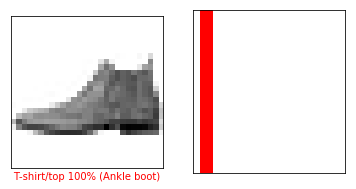

In [14]:
#print the first image and its prediction
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

It shows that the model is 100 percent confidence that this image is not T-shirt/top but an ankle boot instead.

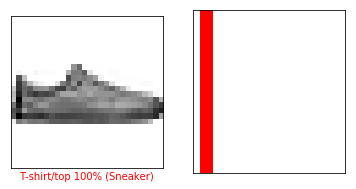

In [15]:
#another image example
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions,  test_labels)

It shows that the model is 100 percent confidence that this image is not T-shirt/top but sneaker instead.

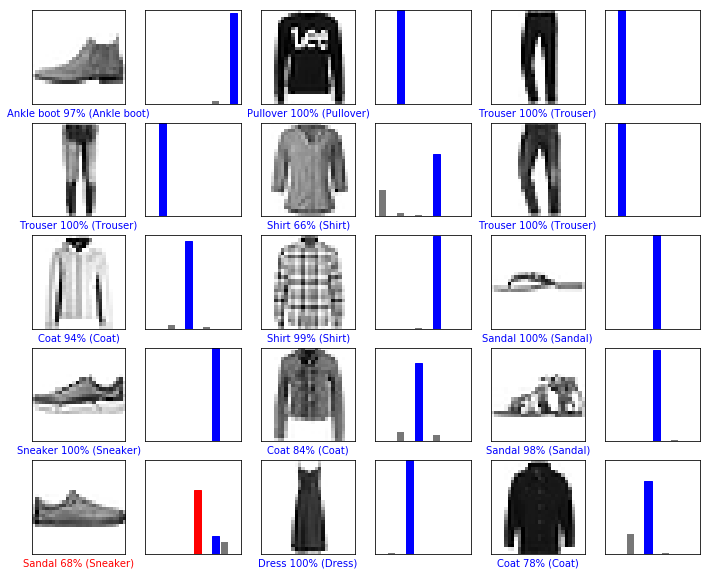

In [33]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels)

We can see several images with its confidence level. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percent (out of 100) for the predicted label.

We can also make a prediction of a single image by using the following code.

In [15]:
# Grab an image from the test dataset
img = test_images[0]
print(img.shape)

(28, 28)


Because the model is set up make a predictions on a collection, then we have to add the single image into a list.

In [16]:
# Add the image to a batch where it's the only member.
img = (np.expand_dims(img,0))
print(img.shape)

(1, 28, 28)


Then, we can make a prediction of the image.

In [17]:
predictions_single = model.predict(img)
print(predictions_single)

[[5.4020773e-05 7.1335272e-08 8.1619902e-07 1.1596932e-06 5.6594740e-06
  6.5306043e-03 7.4253352e-05 4.6493504e-02 2.9685511e-04 9.4654304e-01]]


Call the `plot_value_array` to show the prediction.

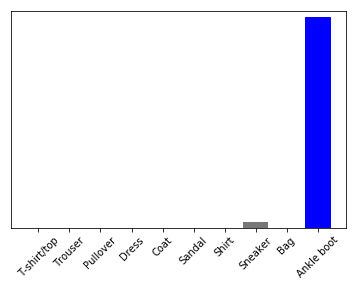

In [38]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

and grab the predictions for only the image that we want to focus on.

In [30]:
np.argmax(predictions_single[0])

9

### 1. Auto-encoding
Autoencoding is a process in which neural network is used to reproduce the input at the output layer which means that the number of input layer is exactly the same as output layer. As shown on the above code, the encoder needs three layers: an input layer, a hidden (encoding) layer, and a decoding layer. The network will train to reconstruct the input and make the hidden layer to produce a good representation of the input. 

In short, in the auto-encoding process, the autoencoder will create a representation of the input at the output layer to make both representation to be as close as possible. The actual used of encoders is to determine a compressed version of the input data with the least amount of loss in data. The concept is to breaks down the input data to a compressed version and make sure that the important part of the data is not lost but the overall size of the data is reduced significantly. It really help in interpreting the classification of the data as it differentiate the data based on the specification that we provided.



`Note: reference:`
* https://towardsdatascience.com/deep-autoencoders-using-tensorflow-c68f075fd1a3
* Accessed on: 11/04/2018

### 2. Applied Unsupervised Learning


In this part, we are going to applied supervised learning to the fashion dataset. We are going to applied the KMeans clustering to data set `train_images`.
The following code will declare the `KMeans` clustering and then `fit` the dataset.

In [48]:
# import Kmeans from sklearn, try with different values of cluster group (1-10)
from sklearn.cluster import KMeans
km = KMeans(n_clusters=10, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_km = km.fit_predict(train_images[:,1,:])

We can plot it in order to have a visual interpretation of the classification.

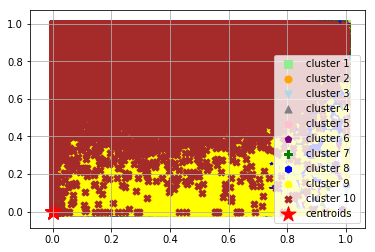

In [50]:
''' It is recommended to use different markers and colors for each class/clusters'''

# Use scatter plot matrix to visualize the samples and the centroids
plt.scatter(train_images[y_km ==0,0], train_images[y_km ==0,1], s=50, c='lightgreen', marker='s', label='cluster 1')
plt.scatter(train_images[y_km ==1,0], train_images[y_km ==1,1], s=50, c='orange', marker='o', label='cluster 2')
plt.scatter(train_images[y_km ==2,0], train_images[y_km ==2,1], s=50, c='lightblue', marker='v', label='cluster 3')
plt.scatter(train_images[y_km ==3,0], train_images[y_km ==3,1], s=50, c='grey', marker='^', label='cluster 4')
plt.scatter(train_images[y_km ==4,0], train_images[y_km ==4,1], s=50, c='pink', marker='8', label='cluster 5')
plt.scatter(train_images[y_km ==5,0], train_images[y_km ==5,1], s=50, c='purple', marker='p', label='cluster 6')
plt.scatter(train_images[y_km ==6,0], train_images[y_km ==6,1], s=50, c='green', marker='P', label='cluster 7')
plt.scatter(train_images[y_km ==7,0], train_images[y_km ==7,1], s=50, c='blue', marker='h', label='cluster 8')
plt.scatter(train_images[y_km ==8,0], train_images[y_km ==8,1], s=50, c='yellow', marker='H', label='cluster 9')
plt.scatter(train_images[y_km ==9,0], train_images[y_km ==9,1], s=50, c='brown', marker='X', label='cluster 10')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], s=250, marker='*', c='red', label='centroids')
plt.legend()
plt.grid()
plt.show()
plt.figure.figsize= (50,50)

As we can see on the above output, the data has been classified into 10 different cluster differentiated by color and symbols.